<h1 style="text-align:center;">Generate all plots 🧀</h1>

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## A smoothing function

We smoothed some of the curves for legibility. To quickly check where this happened, do a ctrl+F on "moving_average".
To disable this smoothing, uncomment the final line in the following block and re-run the notebook.

In [2]:
def moving_average(x, w):
    # First convolve with vector of ones of width w
    convolution = np.convolve(x, np.ones(w), 'same') / w
    
    # Handle edge effects gracefully
    for idx in range((w-1)//2):
        convolution[idx] *= w / ((w-1)//2 + idx+1)
        convolution[-idx-1] *= w / ((w-1)//2 + idx+1)
    return convolution

## To disable smoothing in all plots, uncomment the following line.
# moving_average = (lambda x,w : x)

## Curvature slices
This block generates Figure 1 in the paper.

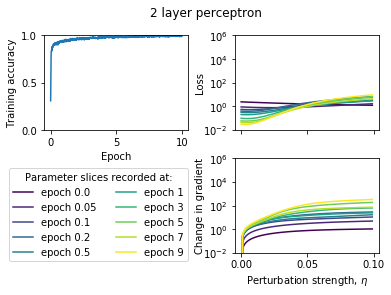

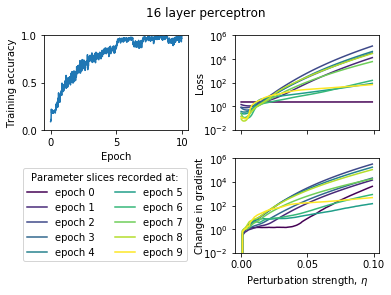

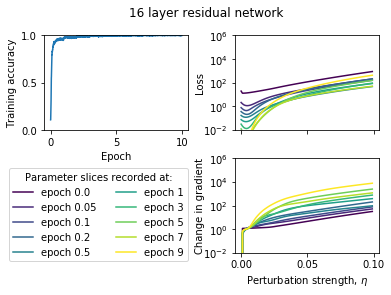

In [8]:
for depth, residual in [(1,False), (15,False), (15,True)]:
    num_steps=100
    epochs=10
    if residual:
        grad_changes = np.load(f'logs/mnist-curvature/residual{residual}_depth{depth}_grad_changes.npy',allow_pickle=True)[0:10]
        loss_slices = np.load(f'logs/mnist-curvature/residual{residual}_depth{depth}_loss_slices.npy',allow_pickle=True)[0:10]
        training_acc = np.load(f'logs/mnist-curvature/residual{residual}_depth{depth}_training_acc.npy',allow_pickle=True)[0:240*10]
    else:
        grad_changes = np.load(f'logs/mnist-curvature/depth{depth}_grad_changes.npy',allow_pickle=True)[0:10]
        loss_slices = np.load(f'logs/mnist-curvature/depth{depth}_loss_slices.npy',allow_pickle=True)[0:10]
        training_acc = np.load(f'logs/mnist-curvature/depth{depth}_training_acc.npy',allow_pickle=True)[0:240*10]
    training_acc = moving_average(training_acc, w=5) # smooth the training acc since it's recorded on minibatches
    perturbation_list = np.array(range(num_steps))*0.001

    def ax_plot(ax, curves):
        colors = plt.cm.viridis(np.linspace(0,1,epochs))
        for epoch in range(epochs):
            curve = curves[epoch]
            ax.plot(perturbation_list, curve, color=colors[epoch])

    fig,a =  plt.subplots(2,2)
    if residual:
        fig.suptitle(f'{depth+1} layer residual network') # We add one to the depth because the count does not include the output layer.
    else:
        fig.suptitle(f'{depth+1} layer perceptron')
    a[0][0].plot(np.array(range(len(training_acc)))/240,training_acc)
    a[0][0].set_xlabel('Epoch')
    a[0][0].set_ylabel('Training accuracy')
    a[0][0].set_ylim(0.0,1)
    a[0][0].set_yticks([0.0,0.5,1])

    a[1][0].axis('off')

    ax_plot(a[0][1], loss_slices)
    a[0][1].set_ylabel('Loss')
    a[0][1].set_xticklabels([])
    a[0][1].set_yscale("log")
    a[0][1].yaxis.labelpad = -2.0
    a[0][1].set_yticks([0.01,1,100,10000,1000000])
    a[0][1].set_ylim(10**-2,10**6)

    ax_plot(a[1][1], grad_changes)
    a[1][1].set_xlabel(r'Perturbation strength, $\eta$')
    a[1][1].set_ylabel('Change in gradient')
    a[1][1].set_yscale("log")
    a[1][1].set_yticks([0.01,1,100,10000,1000000])
    a[1][1].yaxis.labelpad = -2.0
    a[1][1].set_ylim(10**-2,10**6)
    if depth == 15 and not residual:
        a[1][1].legend(labels = ["epoch "+str(x) for x in range(epochs)], title="Parameter slices recorded at:", loc = 'center left', bbox_to_anchor=(-1.5, 0.4), ncol=2)
    else:
        epoch_list = [0.0, 0.05, 0.1, 0.2, 0.5, 1, 3, 5, 7, 9]
        a[1][1].legend(labels = ["epoch "+str(x) for x in epoch_list], title="Parameter slices recorded at:", loc = 'center left', bbox_to_anchor=(-1.6, 0.4), ncol=2)

    plt.subplots_adjust(wspace = 0.32,hspace=0.3)

    plt.savefig(f"figures/curvature_residual{residual}_depth{depth}.pdf", bbox_inches = 'tight', pad_inches = 0)
    plt.show()

## MNIST depth
This block generates Figure 3 (left) in the paper.

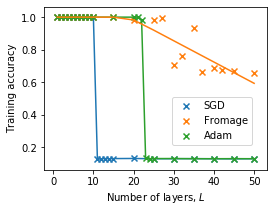

In [4]:
import os

directory = "logs/mnist-depth/100_epochs"

opt_list = ["SGD", "fromage", "adam"]
opt_list_pretty = ["SGD", "Fromage", "Adam"]
layer_list_orig = list(range(1,10)) + [10,15,20,25,30,35,40,45,50]

sgd_lrs = [1.0, 0.1, 0.01]
fromage_lrs = [0.1, 0.01, 0.001]
adam_lrs = [0.01, 0.001, 0.0001]

fig,a =  plt.subplots(1,1,figsize=(4,3))

for opt,alg,zorder in zip(opt_list,opt_list_pretty,[0,2,1]):
    layer_list = layer_list_orig + [] # add empty list to force a copy
    if opt == "SGD" or opt == "SGDwithoutmomentum": 
        lr_list = sgd_lrs
        layer_list += [11,12,13,14]
    if opt == "fromage": 
        lr_list = fromage_lrs
        layer_list += [27,32,37,42]
    if opt == "adam": 
        lr_list = adam_lrs
        layer_list += [21,22,23,24]
    layer_list.sort()
        
    last_epoch_means = []
            
    for layer_num in layer_list:
        train_accs = np.zeros((3,24000))
        for lr_idx, lr in enumerate(lr_list):
            filename = f'{opt}_layers_{layer_num}_initlr_{lr}_epochs100.npy'
            train_accs[lr_idx,:] = np.load(os.path.join(directory, filename))
        train_acc = np.max(train_accs,axis=0)
        last_epoch_mean = np.mean(train_acc[-240:])
        last_epoch_means.append(last_epoch_mean)
    a.scatter(layer_list,last_epoch_means,marker='x',label=alg)
    
    smoothed = np.asarray(last_epoch_means)
    if opt == "fromage":
        n = 10
        coefs = np.polyfit(layer_list[-n:], last_epoch_means[-n:],1)
        poly = np.poly1d(coefs)
        smoothed[-n:]= poly(layer_list[-n:])
    
    a.plot(layer_list,smoothed,zorder=zorder)
a.legend(bbox_to_anchor=(0.55,0.48))
a.set_xlabel(r'Number of layers, $L$')
a.set_ylabel("Training accuracy")
plt.savefig(f"figures/mnist-depth-100.pdf", bbox_inches = 'tight', pad_inches = 0.01)
plt.show()

## Validating the effect of stability correction
Here we plot the norms for all spectrally normalised layers in a GAN training run. The LARS version takes the Fromage code and comments out the stability correction. This generates the plot for Figure 2 (right).

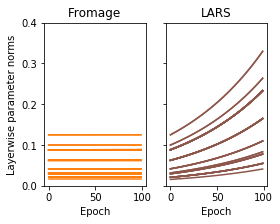

In [5]:
from tensorboard.backend.event_processing import event_accumulator

alg_list = ['fromage', 'lars']
alg_list_pretty = ['Fromage', 'LARS']
color_list = ['C1','C5']

fig,a =  plt.subplots(1,2,figsize=(4,3))

for ax, alg, alg_pretty, color in zip([0,1],alg_list,alg_list_pretty,color_list):
    ea = event_accumulator.EventAccumulator(f'logs/cifar-gan/{alg}-0.01-seed0')
    ea.Reload()
        
    for tag in ea.Tags()['scalars']:
        if "weight_orig" in tag:
            series = [item.value for item in ea.Scalars(tag)][0:100] # lr decay happens at epoch 100
            a[ax].plot(series,color=color)
    a[ax].set_ylim((0,0.4))
    a[ax].set_title(alg_pretty)
    a[ax].set_xlabel("Epoch")
    a[ax].set_xticks([0,50,100])
    a[ax].set_yticks([0.0,0.1,0.2,0.3,0.4])
a[0].set_ylabel("Layerwise parameter norms")
a[1].set_yticklabels([])
plt.savefig(f"figures/lars-norms.pdf", bbox_inches = 'tight', pad_inches = 0)
plt.show()

## Learning rate comparison
This generates Figure 3 (right).

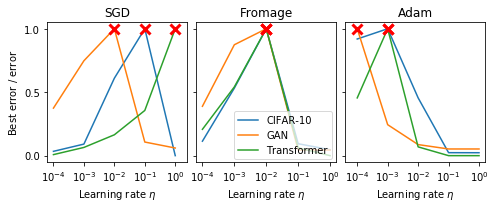

In [6]:
fig, ax = plt.subplots(1,3, figsize=(7,3))
plt.setp(ax, xticks=[0,1,2,3,4], yticks=[0.0,0.5,1.0], xticklabels=['$10^0$','$10^{-1}$','$10^{-2}$','$10^{-3}$','$10^{-4}$'][::-1])

def metric_normalize(values):
    return (min(values) / values) * 1.0
    
# SGD
cifar_10_results = [1000, 0.05356, 0.08779, 0.5878, 1.572][::-1] # training loss at epoch 50. first result NaN (unstable)
gan_results = [679.7, 381.4, 40.92, 54.73, 109.2][::-1] # FID at epoch 100
transformer_results = [167.7, 470.9, 1020, 2589, 20341][::-1] # train ppl at epoch 10

cifar_10_results = np.array(cifar_10_results)
gan_results = np.array(gan_results)
transformer_results = np.array(transformer_results)

cifar_10_results = metric_normalize(cifar_10_results)
gan_results = metric_normalize(gan_results)
transformer_results = metric_normalize(transformer_results)

x_axis = np.arange(len(cifar_10_results))
ax[0].plot(x_axis, cifar_10_results, label='CIFAR-10')
ax[0].plot(x_axis, gan_results, label='CIFAR-10 cGAN')
ax[0].plot(x_axis, transformer_results, label='Wikitext-2')
ax[0].scatter([2,3,4],[1,1,1],marker='x',c='r',s=100,zorder=10,linewidth=3)
ax[0].set_title('SGD')

# Fromage
cifar_10_results = [2.303, 1.145, 0.1077, 0.2023, 0.9455][::-1]
gan_results = [679.7,679.7,29.94,34.26,76.97][::-1]
transformer_results = [1.9643*10**10,1619,100.9,186.3,486.1][::-1]

cifar_10_results = np.array(cifar_10_results)
gan_results = np.array(gan_results)
transformer_results = np.array(transformer_results)

cifar_10_results = metric_normalize(cifar_10_results)
gan_results = metric_normalize(gan_results)
transformer_results = metric_normalize(transformer_results)

x_axis = np.arange(len(cifar_10_results))
ax[1].plot(x_axis, cifar_10_results, label='CIFAR-10')
ax[1].plot(x_axis, gan_results, label='GAN')
ax[1].plot(x_axis, transformer_results, label='Transformer')
ax[1].scatter([2,2,2],[1,1,1],marker='x',c='red',s=100,zorder=10,linewidth=3)
ax[1].set_title('Fromage')

# Adam
cifar_10_results = [2.347,2.31,0.119,0.0542,0.05897][::-1]
gan_results = [497.5,497.6,300.3,107.3,26.18][::-1] # lr 1.0 unstable
transformer_results = [10**10,4.5888*10**8,816.3,56.38,123.9][::-1]

cifar_10_results = np.array(cifar_10_results)
gan_results = np.array(gan_results)
transformer_results = np.array(transformer_results)

cifar_10_results = metric_normalize(cifar_10_results)
gan_results = metric_normalize(gan_results)
transformer_results = metric_normalize(transformer_results)

x_axis = np.arange(len(cifar_10_results))
ax[2].plot(x_axis, cifar_10_results, label='CIFAR-10')
ax[2].plot(x_axis, gan_results, label='CIFAR-10 cGAN')
ax[2].plot(x_axis, transformer_results, label='Wikitext-2')
ax[2].scatter([0,1,1],[1,1,1],marker='x',c='red',s=100,zorder=10,linewidth=3)
ax[2].set_title('Adam')

for ax_idx in [0,1,2]:
    ax[ax_idx].set_xlabel('Learning rate $\eta$')
    ax[ax_idx].set_ylim(-0.05,1.05)
    ax[ax_idx].set_yticklabels([])
ax[0].set_yticklabels([0.0,0.5,1.0])
    
ax[1].legend(loc='upper center', bbox_to_anchor=(0.62, 0.4), framealpha=0.75)
ax[0].set_ylabel('Best error $/$ error')
fig.tight_layout(w_pad=0.)
plt.show()
fig.savefig('figures/lr-compare.pdf', bbox_inches='tight',pad_inches = 0.01)